# BOSS Calibration Tutorial

The purpose of this tutorial is to reconstruct and document the calibration steps from detected electrons to calibrated flux, as described [here](https://trac.sdss3.org/wiki/BOSS/pipeline/FluxToPhotons) (requires SDSS3 login).

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import astropy.io.fits as fits

In [3]:
import bossdata
print(bossdata.__version__)

0.3.1dev


In [4]:
finder = bossdata.path.Finder()
mirror = bossdata.remote.Manager()

Define a utility function to take the inverse of an array that might be masked or contain zeros. The result is always an unmasked array with any invalid entries set to zero.

In [5]:
def inverse(data):
    if isinstance(data, ma.core.MaskedArray):
        # Add any zero entries to the original mask.
        mask = data.mask
        mask[~data.mask] = (data[~data.mask] == 0)
    else:
        mask = (data == 0)
    inv = np.zeros(data.shape)
    inv[~mask] = 1 / data[~mask]
    return inv

Catch any warnings since there shouldn't be any:

In [6]:
#import warnings

In [7]:
#warnings.simplefilter('error')

With the default plate 6641, all files are mirrored from https://dr12.sdss.org/sas/dr12/boss/spectro/redux/v5_7_0/6641/.

In [8]:
def plot_calib(plate=6641, mjd=None, fiber=1, expidx=0, band='blue',
               mask=None, save=None):
    """
    """
    assert band in ('blue', 'red')
    
    # Infer the MJD if possible, when none is specified.
    if mjd is None:
        mjds = bossdata.meta.get_plate_mjd_list(plate, finder, mirror)
        if len(mjds) == 0:
            print('Plate {} has never been observed with good quality.')
        elif len(mjds) > 1:
            print('Plate {} observed multiple on multiple MJDs (pick one): {}.'
                  .format(','.join(mjds)))
        else:
            mjd = mjds[0]
            print('Using MJD {}.'.format(mjd))
        if not mjd:
            return

    # Which spectrograph does this fiber belong to?
    num_fibers = bossdata.plate.get_num_fibers(plate)
    spec_num = 1 if fiber <= num_fibers // 2 else 2
    camera = band[0] + str(spec_num)
    print('Fiber {} read out by {} camera {}.'.format(fiber, band, camera))

    # Load the list of exposures used for the science coadd of PLATE-MJD
    # and the associated calibration exposures.
    spec_name = finder.get_spec_path(plate, mjd, fiber, lite=True)
    exposures = bossdata.spec.SpecFile(mirror.get(spec_name)).exposures
    
    nexp = len(exposures.table)
    if expidx >= nexp:
        print('Invalid exposure index {} (should be 0-{}).'
              .format(expidx, nexp - 1))
        return
    expnum = exposures.table[expidx]['science']
    print('Analyzing exposure[{}] = #{} of {} used in coadd.'
          .format(expidx, expnum, nexp))
        
    # Load the calibrated flux and wavelength solution and ivars from the spCFrame file.
    name = exposures.get_exposure_name(expidx, camera, 'spCFrame')
    path = mirror.get(finder.get_plate_path(plate, name))
    spCFrame = bossdata.plate.FrameFile(path, calibrated=True)
    data = spCFrame.get_valid_data(
        [fiber], include_sky=True,use_ivar=True, pixel_quality_mask=mask)[0]
    wave, flux, sky, ivar = data['wavelength'], data['flux'], data['sky'], data['ivar']
    
    # Lookup the metadata for this fiber.
    fiber_index = spCFrame.get_fiber_offsets([fiber])[0]
    info = spCFrame.plug_map[fiber_index]
    objtype = info['OBJTYPE'].rstrip()
    print('Fiber {} objtype is {}.'.format(fiber, objtype))
    
    # Load the uncalibrated flux in flat-fielded electrons from the spFrame file.
    name = exposures.get_exposure_name(expidx, camera, 'spFrame')
    path = mirror.get(finder.get_plate_path(plate, name))
    spFrame = bossdata.plate.FrameFile(path, calibrated=False)
    data = spFrame.get_valid_data(
        [fiber], include_sky=True, use_ivar=True, pixel_quality_mask=mask)[0]
    ewave, eflux, esky, eivar = data['wavelength'], data['flux'], data['sky'], data['ivar']
    
    # Look up the trace position on the CCD.
    tracex = spFrame.hdulist[7].read()[fiber_index]
    
    # Load the fluxcorr for this fiber.
    name = exposures.get_exposure_name(expidx, camera, 'spFluxcorr')
    path = mirror.get(finder.get_plate_path(plate, name))
    with fits.open(path) as spFluxcorr:
        corr = spFluxcorr[0].data[fiber_index]

    # Load the fluxcalib for this fiber.
    name = exposures.get_exposure_name(expidx, camera, 'spFluxcalib')
    path = mirror.get(finder.get_plate_path(plate, name))
    with fits.open(path) as spFluxcalib:
        spcalib = spFluxcalib[0].data[fiber_index]
        
    # The spFrame uses a TraceSet instead of tabulated log(lambda) values.
    # The b-camera spCFrame, spFluxcorr arrays have 16 extra entries compared
    # with spFrame, so trim those now.
    n = len(ewave)
    wave = wave[:n]
    assert np.allclose(wave, ewave)
    flux = flux[:n]
    sky = sky[:n]
    ivar = ivar[:n]
    corr = corr[:n]
    
    # Load the superflat from the spFrame file.
    superflat = spFrame.get_superflat([fiber])[0]
    
    # Load the fiberflat and neff from the spFlat file.
    name = exposures.get_exposure_name(expidx, camera, 'spFlat')
    path = mirror.get(finder.get_plate_path(plate, name))
    with fits.open(path) as spFlat:
        fiberflat = spFlat[0].data[fiber_index]
        neff = bossdata.plate.TraceSet(spFlat[3]).get_y()[fiber_index]
        
    # Get the flux distortion map for this plate's coadd.
    path = mirror.get(finder.get_fluxdistort_path(plate, mjd))
    with fits.open(path) as spFluxdistort:
        distort_coadd = spFluxdistort[0].data[fiber_index]
        # Build the coadded loglam grid.
        hdr = spFluxdistort[0].header
        loglam0, idx0, dloglam = hdr['CRVAL1'], hdr['CRPIX1'], hdr['CD1_1']
        loglam = loglam0 + (np.arange(len(distort_coadd)) - idx0) * dloglam
        wave_coadd = 10 ** loglam
        # Linearly interpolate the distortion to our wavelength grid.
        distort = np.interp(wave, wave_coadd, distort_coadd)
        # Calculate ratio of dloglam=10e-4 bin sizes to native pixel binsizes.
        R = dloglam / np.gradient(np.log10(wave))
        
    # Combine the flat-field corrections.
    flat = superflat * fiberflat
    
    # Calculate the raw electron counts, including the sky. Note that this
    # can be negative due to read noise.
    electrons = flat * (eflux + esky)
    
    # Lookup the measured readnoise measured in each amplifier quadrant.
    readnoise_per_quad = np.empty(4)
    for quadrant in range(4):
        readnoise_per_quad[quadrant] = spFrame.header['RDNOISE{}'.format(quadrant)]
    print('Readnoise is {:.2f}/{:.2f}/{:.2f}/{:.2f} electrons'
          .format(*readnoise_per_quad))
    
    # Get the quadrant of each wavelength pixel along this trace.
    ampsizes = {'blue': (2056, 2048), 'red': (2064, 2057)}
    ysize, xsize = ampsizes[band]
    yamp = 1 * (np.arange(2 * ysize) >= ysize)
    xamp = 2 * (tracex >= xsize)
    quad = xamp + yamp
    
    # Lookup the read noise for each wavelength pixel along this trace.
    readnoise_per_pixel = readnoise_per_quad[quad]
    mean_readnoise = np.mean(readnoise_per_pixel)
    
    # Estimate the readnoise per wavelength pixel.
    # Why is scale~2.35 necessary to reproduce the pipeline noise??
    ##scale = np.sqrt(8 * np.log(2))
    scale = (4 * np.pi) ** 0.25
    readnoise = readnoise_per_pixel * neff * scale
    
    # Calculate the pipeline variance in detected electrons.
    evar = flat ** 2 * inverse(eivar)
    
    # Predict what the variance in detected electrons should be.
    # Clip bins with electrons < 0 (due to read noise), to match what
    # the pipeline does (in sdssproc).
    evar_pred = np.clip(electrons, a_min=0, a_max=None) + readnoise ** 2
    
    # Calculate the actual flux / eflux calibration used by the pipeline.
    ecalib1 = flux * inverse(eflux)
    
    # Calculate the flux / eflux calibration from the components described at
    # https://trac.sdss3.org/wiki/BOSS/pipeline/FluxToPhotons
    ecalib2 = corr * distort * R * inverse(spcalib)

    # Compare the actual and predicted calibrations.
    nonzero = (ecalib1 > 0)
    absdiff = np.abs(ecalib1[nonzero] - ecalib2[nonzero])
    reldiff = absdiff / np.abs(ecalib1[nonzero] + ecalib2[nonzero])
    print('calibration check: max(absdiff) = {:.5f}, max(reldiff) = {:.5f}'
          .format(np.max(absdiff), np.max(reldiff)))
    
    # Calculate the flux variance.
    var = inverse(ivar)
    
    # Predict the flux variance by scaling the eflux variance.
    var_pred = ecalib1 ** 2 * inverse(eivar)
    
    # Limit plots to wavelengths where the flat is nonzero.
    nonzero = np.where(flat > 0)[0]
    wmin, wmax = wave[nonzero[[0,-1]]]
    
    # Truncate tails.
    evar_max = np.percentile(evar, 99)
    var_max = np.percentile(var, 99)
    
    # Initialize plots.
    fig, ax = plt.subplots(3, 2, figsize=(8.5, 11))
    ax = ax.flatten()

    ax[0].plot(wave, flux + sky, 'k.', ms=1, label='flux+sky')
    ax[0].plot(wave, var, 'r.', ms=1, label='var')
    ax[0].plot(wave, var_pred, 'b.', ms=1, label='pred')
    ax[0].set_xlim(wmin, wmax)
    ax[0].set_ylim(0, np.percentile(flux + sky, 99))
    ax[0].set_xlabel('Wavelength [A]')
    ax[0].set_ylabel('Flux, Variance [flux]')
    ax[0].legend(ncol=3)

    ax[1].plot(wave, eflux + esky, 'k.', ms=1, label='flux+sky')
    ax[1].plot(wave, evar, 'r.', ms=1, label='var')
    ax[1].plot(wave, evar_pred, 'b.', ms=1, label='pred')
    ax[1].plot(wave, readnoise, 'g-', label='readnoise')
    ax[1].set_xlim(wmin, wmax)
    ax[1].set_ylim(0, evar_max)
    ax[1].set_xlabel('Wavelength [A]')
    ax[1].set_ylabel('Flux, Variance [elec]')
    ax[1].legend(ncol=2)
    
    ax[2].plot(wave, flat, 'k-', label='both')
    ax[2].plot(wave, superflat, 'r-', label='super')
    ax[2].plot(wave, fiberflat, 'b-', label='fiber')
    ax[2].set_xlim(wmin, wmax)
    ax[2].set_xlabel('Wavelength [A]')
    ax[2].set_ylabel('Flat Field Correction')
    ax[2].legend(ncol=3)
    
    ax[3].plot(wave, ecalib1, 'k-', label='All')
    ax[3].plot(wave, corr, 'b-', label='corr')
    ax[3].plot(wave, 5 * inverse(spcalib), 'r-', label='5/spcalib')
    ax[3].plot(wave, distort, '-', c='magenta', label='distort')
    ax[3].plot(wave, R, 'g-', label='R')
    ax[3].set_xlim(wmin, wmax)
    ax[3].set_xlabel('Wavelength [A]')
    ax[3].set_ylabel('Flux Calibration [flux/elec]')
    ax[3].legend(ncol=3)
    
    '''
    ax[4].plot(var_pred, var, 'k.', ms=1)
    ax[4].set_xlim(0, var_max)
    ax[4].set_ylim(0, var_max)
    ax[4].set_xlabel('Predicted Variance [flux]')
    ax[4].set_ylabel('Pipeline Variance [flux]')
    '''
    excess_rms_per_pix = np.sqrt(evar - electrons)
    ax[4].plot(wave, excess_rms_per_pix, 'k.', ms=1)
    ax[4].plot(wave, readnoise, 'r-')
    ax[4].set_xlim(wmin, wmax)
    ax[4].set_ylim(0., np.percentile(excess_rms_per_pix, 95))
    ax[4].set_xlabel('Wavelength [A]')
    ax[4].set_ylabel('(Pipeline Var - Shot Noise)$^{1/2}$ [det elec]')

    ax[5].plot(evar_pred, evar, 'k.', ms=1)
    ax[5].plot([0, evar_max], [0, evar_max], 'r--')
    ax[5].set_xlim(0, evar_max)
    ax[5].set_ylim(0, evar_max)
    ax[5].set_xlabel('Predicted Variance [det elec$^2$]')
    ax[5].set_ylabel('Pipeline Variance [det elec$^2$]')
    
    title = '{}-{}-{} {}[{}]={} OBJ={} RDNOISE={:.1f}e'.format(
        plate, mjd, fiber, camera, expidx, expnum, objtype, mean_readnoise)
    plt.suptitle(title)
    plt.subplots_adjust(top=0.95, right=0.99)
    if save:
        plt.savefig(save)

Using MJD 56383.
Fiber 1 read out by blue camera b1.
Analyzing exposure[0] = #158842 of 14 used in coadd.
Fiber 1 objtype is QSO.
Readnoise is 2.24/2.18/2.07/2.04 electrons
calibration check: max(absdiff) = 0.00017, max(reldiff) = 0.00076


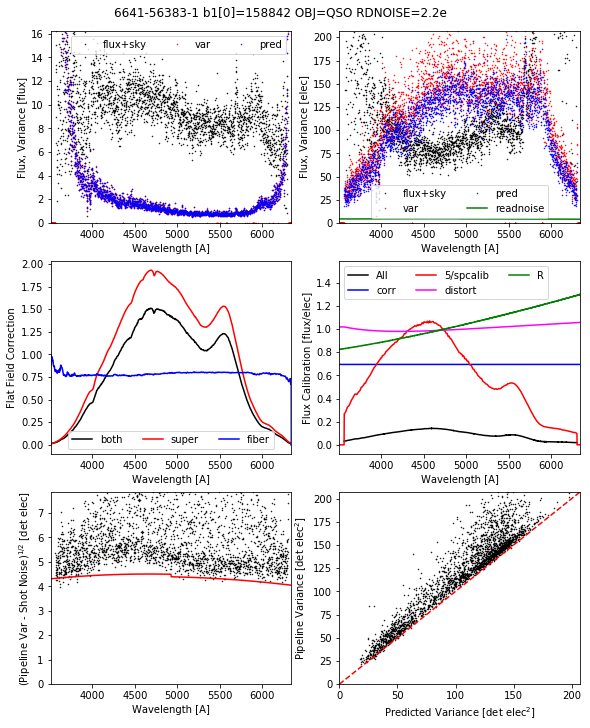

In [9]:
plot_calib(fiber=1, band='blue')

Using MJD 56383.
Fiber 1 read out by red camera r1.
Analyzing exposure[0] = #158842 of 14 used in coadd.
Fiber 1 objtype is QSO.
Readnoise is 2.90/2.59/2.53/2.52 electrons
calibration check: max(absdiff) = 0.00116, max(reldiff) = 0.02025


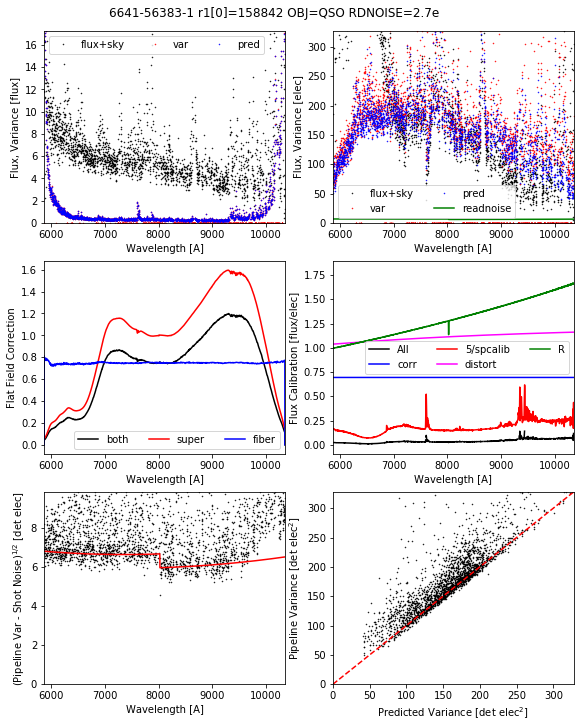

In [10]:
plot_calib(fiber=1, band='red')

Using MJD 56383.
Fiber 486 read out by blue camera b1.
Analyzing exposure[0] = #158842 of 14 used in coadd.
Fiber 486 objtype is SKY.
Readnoise is 2.24/2.18/2.07/2.04 electrons
calibration check: max(absdiff) = 0.00029, max(reldiff) = 0.00075


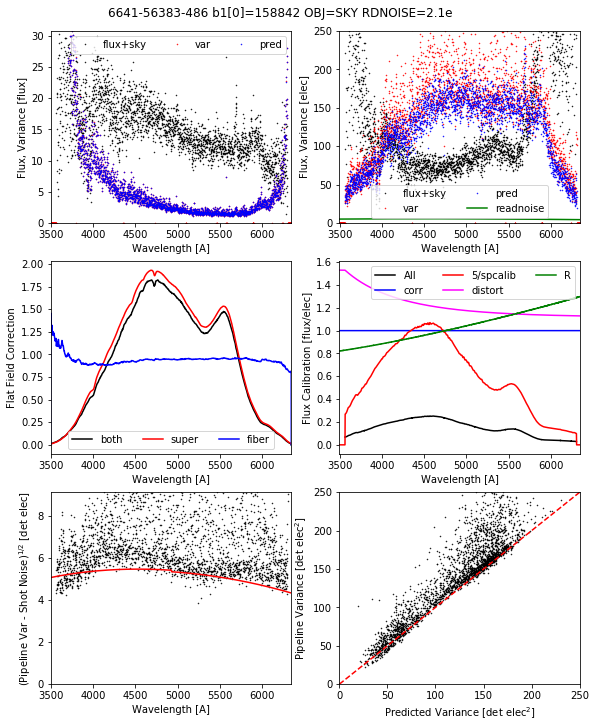

In [11]:
plot_calib(fiber=486, band='blue')

Using MJD 56383.
Fiber 486 read out by red camera r1.
Analyzing exposure[0] = #158842 of 14 used in coadd.
Fiber 486 objtype is SKY.
Readnoise is 2.90/2.59/2.53/2.52 electrons
calibration check: max(absdiff) = 0.00173, max(reldiff) = 0.02076


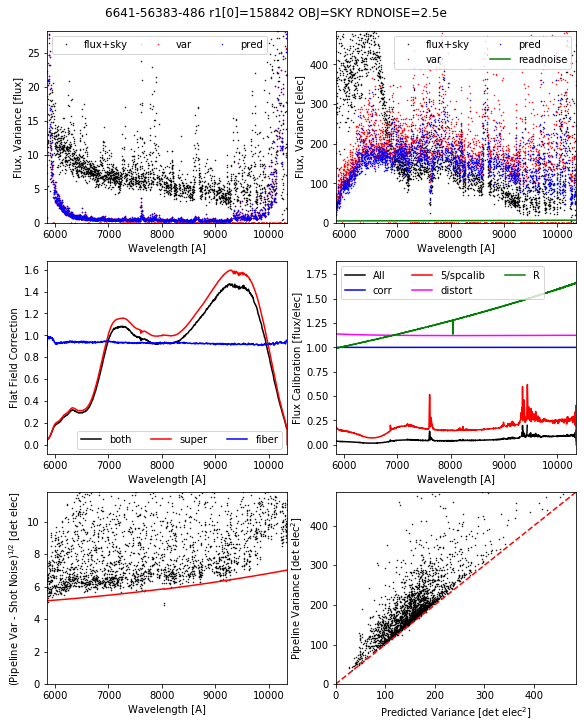

In [12]:
plot_calib(fiber=486, band='red')

Using MJD 56383.
Fiber 12 read out by red camera r1.
Analyzing exposure[0] = #158842 of 14 used in coadd.
Fiber 12 objtype is SKY.
Readnoise is 2.90/2.59/2.53/2.52 electrons
calibration check: max(absdiff) = 0.00133, max(reldiff) = 0.01796


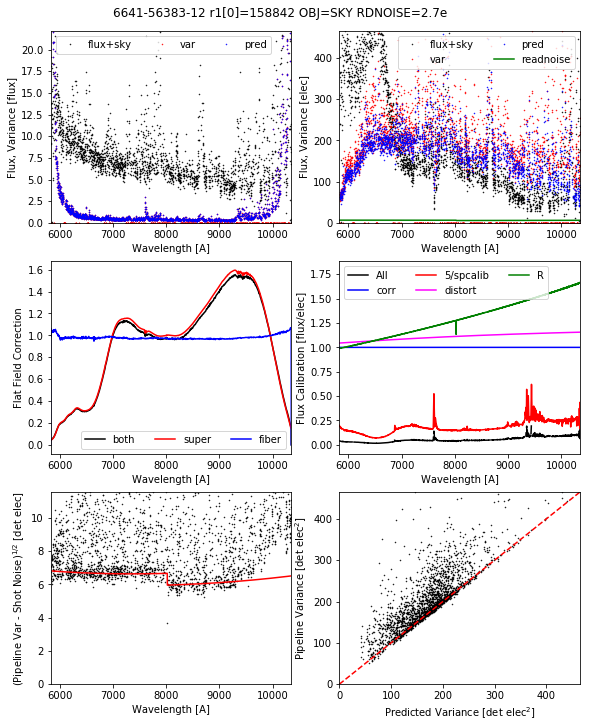

In [13]:
plot_calib(fiber=12, band='red')